In [1]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, LeaveOneOut, LeavePOut
from sklearn.model_selection import RepeatedKFold, cross_val_predict, cross_val_score
from sklearn.model_selection import cross_val_score
import settings
import matplotlib.pyplot as plt

In [2]:
dietary_data_path = f'{settings.output_folder}diet.csv'
targets_path = f'{settings.raw_data_folder}control/regression_targets.csv'
features_food_path = f'{settings.features_folder}selected_features_rfe_shap_food.csv'

In [3]:
food_data = pd.read_csv(dietary_data_path)
food_data = food_data[food_data.columns[2:]].drop(['Confirmed', 'Deaths', 'Recovered'],axis=1)
food_data.head()

,Alcoholic Beverages,Animal Products,Animal fats,"Aquatic Products, Other",Cereals - Excluding Beer,Eggs,"Fish, Seafood",Fruits - Excluding Wine,Meat,Miscellaneous,...,Spices,Starchy Roots,Stimulants,Sugar Crops,Sugar & Sweeteners,Treenuts,Vegetal Products,Vegetable Oils,Vegetables,Country
0,0.000030,0.326636,0.223147,0.0,0.733914,0.132792,0.000638,0.148116,0.133538,0.025586,...,0.090683,0.008648,0.101278,0.0,0.093136,0.113588,0.663569,0.246708,0.320304,Afghanistan
1,0.095202,0.741183,0.154200,0.0,0.146948,0.460113,0.022935,0.274058,0.283455,0.039222,...,0.000402,0.036580,0.119830,0.0,0.145522,0.221400,0.226743,0.149209,0.592018,Albania
2,0.011670,0.274016,0.034457,0.0,0.378697,0.313765,0.024193,0.237088,0.103129,0.076753,...,0.080131,0.086139,0.109900,0.0,0.176586,0.160859,0.745976,0.556105,0.585138,Algeria
3,0.251279,0.199301,0.053595,0.0,0.288345,0.022781,0.184776,0.189200,0.290182,0.051748,...,0.001731,0.534029,0.030582,0.0,0.130798,0.004750,0.764589,0.390946,0.078466,Angola
4,0.226478,0.656624,0.171604,0.0,0.131001,0.118321,0.346861,0.356505,0.621373,0.217600,...,0.216778,0.023982,0.225526,0.0,0.318216,0.043980,0.311472,0.346539,0.249017,Antigua and Barbuda


In [4]:
targets = pd.read_csv(targets_path)
print(f'Missing values: {targets.isnull().sum()}')
targets.head()

Missing values: Deaths       0
Confirmed    0
Recovered    0
Country      0
dtype: int64


,Deaths,Confirmed,Recovered,Country
0,0.006186,0.142134,0.123374,Afghanistan
1,0.050951,2.967301,1.792636,Albania
2,0.006558,0.244897,0.167572,Algeria
3,0.001461,0.061687,0.056808,Angola
4,0.108227,4.356147,3.905192,Argentina


In [5]:
food_data = food_data.merge(targets, on='Country', how='inner')

In [6]:
label_values = ['Deaths', 'Recovered', 'Confirmed']
features_food = food_data.columns.drop(label_values)
features_food = features_food.drop(['Country'])
X_food = food_data[features_food]
Y_food = food_data[label_values]

In [7]:
selected_features_food = pd.read_csv(features_food_path)
selected_features_food = selected_features_food['selected_features']

In [8]:
def hyper_parameter_search(X, Y, params):
  xgb = XGBRegressor(n_jobs=-1)
  gscv = GridSearchCV(xgb, params, n_jobs=-1, scoring='neg_mean_absolute_error', cv=5)
  xgboost_best = gscv.fit(X = X, y=Y)
  return xgboost_best.best_params_, xgboost_best.best_score_

In [9]:
def cross_validation_predictions(regressor, data, target, folds=5):
  scores = {}
  n_folds = RepeatedKFold(n_splits=folds, n_repeats=5, random_state=0)
  scores['neg_mean_absolute_error'] = cross_val_score(regressor, data, target, cv=LeaveOneOut(), scoring='neg_mean_absolute_error', n_jobs=-1).mean()
  scores['neg_median_absolute_error'] = cross_val_score(regressor, data, target, cv=LeaveOneOut(), scoring='neg_median_absolute_error', n_jobs=-1).mean()
  scores['neg_mean_squared_error'] = cross_val_score(regressor, data, target, cv=LeaveOneOut(), scoring='neg_mean_squared_error', n_jobs=-1).mean()
  predictions = cross_val_predict(regressor, data, target, cv=LeaveOneOut(), n_jobs=-1)
  return scores, predictions

In [10]:
PARAMS = {
    'max_depth': [2, 3, 5, 7, 10],
    'min_child_weight': [3, 4, 5, 6],
    'learning_rate': [0.003, 0.05, 0.1, 0.25, 0.5],
    'gamma': [0, 0.1, 0.3],
    'n_estimators': [35, 50, 75, 100, 150, 200, 250, 300, 350]
}

In [11]:
food_params, food_score = hyper_parameter_search(X_food[selected_features_food], Y_food['Deaths'], PARAMS)

In [12]:
print(f'best parameters: {food_params}')
print(f'score: {food_score}')

best parameters: {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 6, 'n_estimators': 150}
score: -0.025751243315388268


In [13]:
xgb_food = XGBRegressor(gamma = food_params['gamma'],
                        learning_rate = food_params['learning_rate'],
                        max_depth = food_params['max_depth'], 
                        min_child_weight = food_params['min_child_weight'],
                        n_estimators = food_params['n_estimators'],
                        random_state=0)

In [14]:
scores_food, predictions_food = cross_validation_predictions(xgb_food, X_food[selected_features_food],
                                                             Y_food['Deaths'])

In [15]:
scores_food

{'neg_mean_absolute_error': -0.02672211566207223,
 'neg_median_absolute_error': -0.02672211566207223,
 'neg_mean_squared_error': -0.0014201061012499665}

In [16]:
print(f'r2_score = {r2_score(Y_food["Deaths"], predictions_food)}')
print(f'mse = {mean_squared_error(Y_food["Deaths"], predictions_food)}')
print(f'mae = {mean_absolute_error(Y_food["Deaths"], predictions_food)}')

r2_score = 0.41153749717175436
mse = 0.0014201061012499665
mae = 0.02672211566207223


In [17]:
abs_difs_food = np.abs(predictions_food - Y_food['Deaths'].values)

In [18]:
ordered_values = []
for i in range(len(abs_difs_food)):
  node = {}
  node['predicted'] = predictions_food[i]
  node['actual'] = Y_food['Deaths'].values[i]
  node['error'] = abs_difs_food[i]
  node['country'] = food_data.iloc[i].Country
  ordered_values.append(node)

ordered_values.sort(key = lambda item: item['error'])

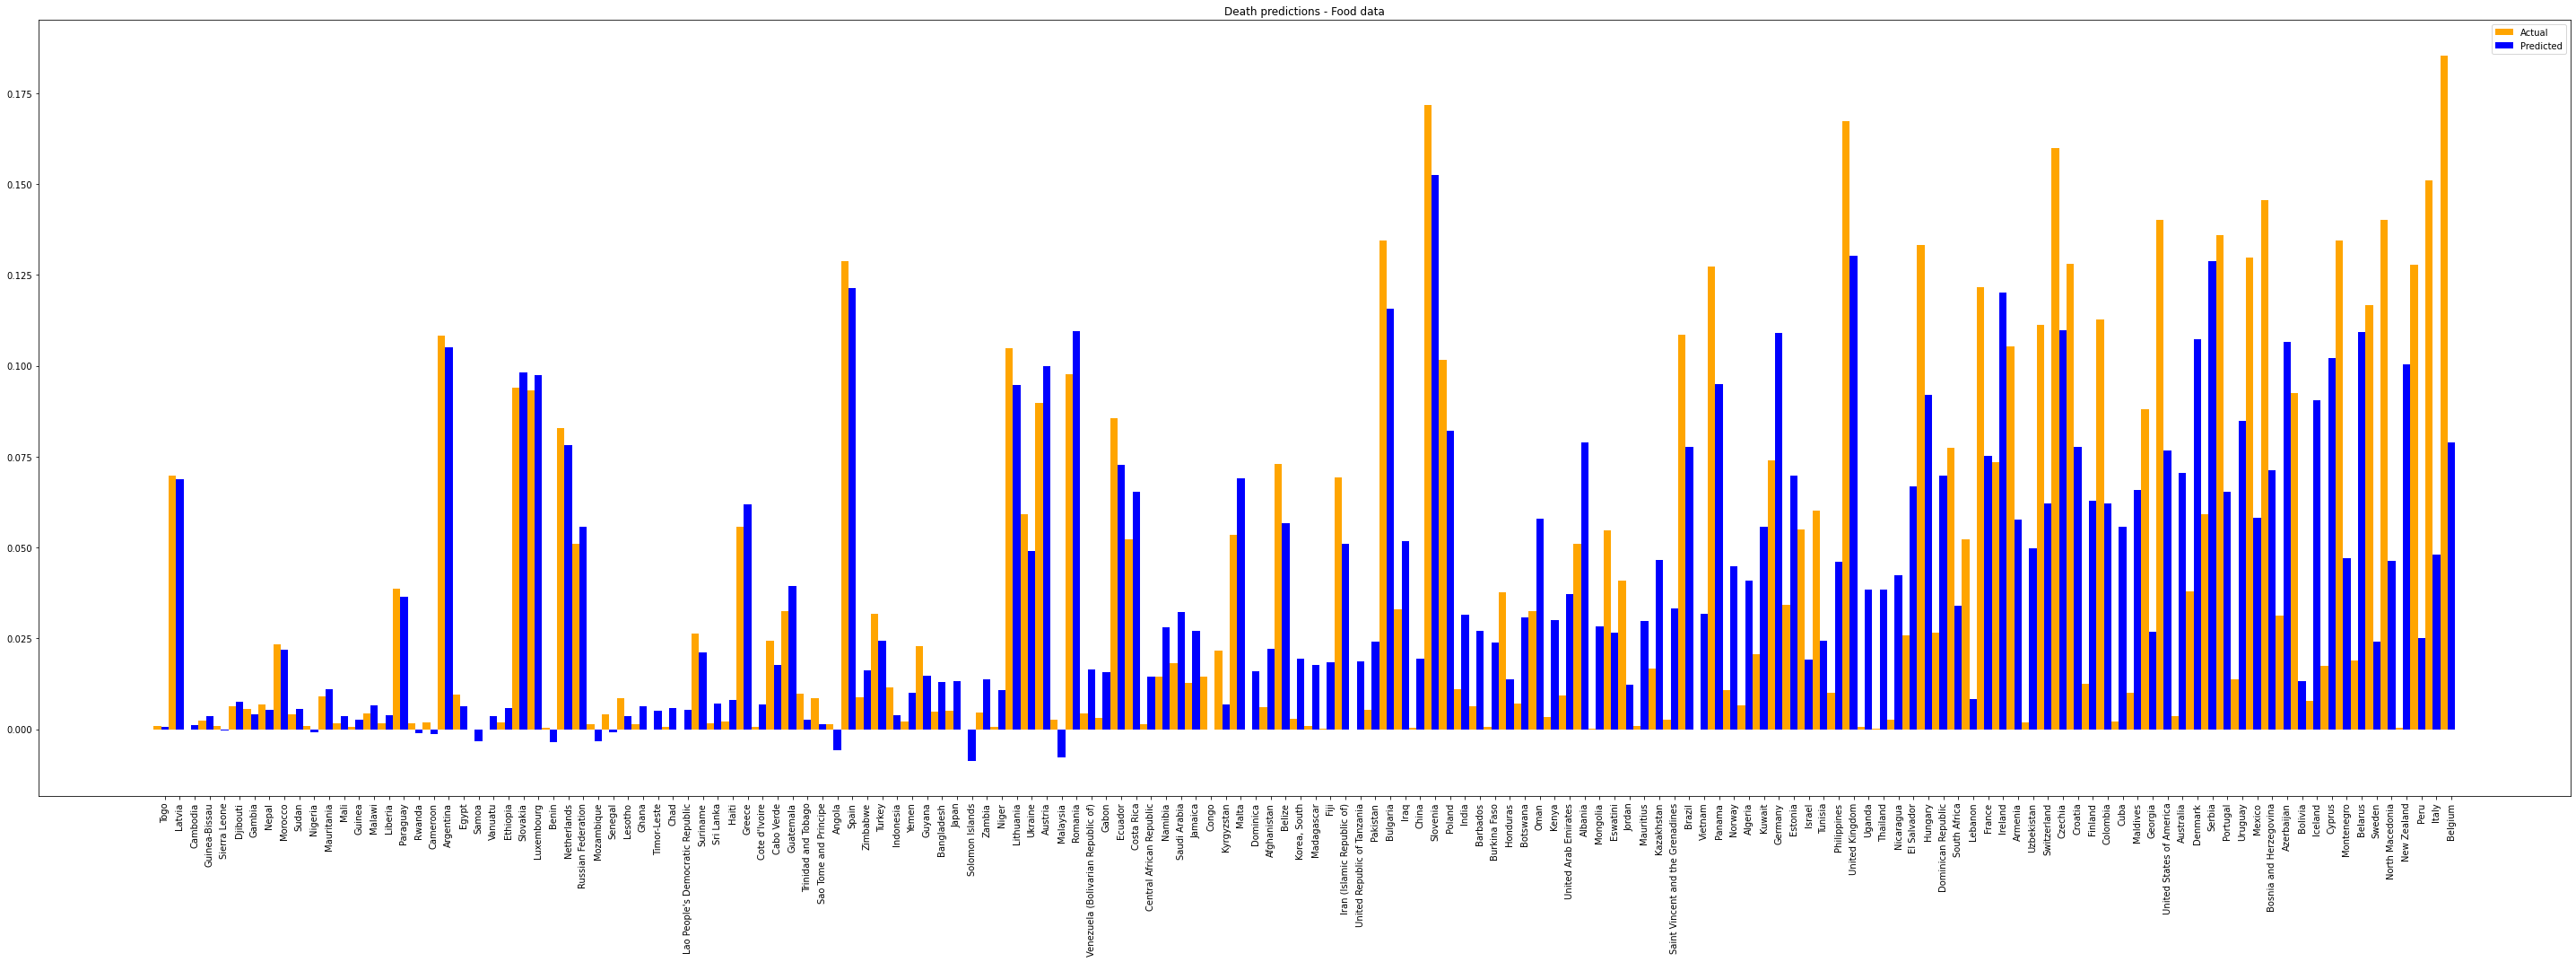

In [19]:
x = np.arange(1, len(X_food) + 1)
plt.figure(figsize=(40, 15))
countries = []
for i, elem in enumerate(ordered_values):
  plt.bar(x[i]-0.5, elem['actual'], width=0.5, color='orange', align='center', label='True values')
  plt.bar(x[i], elem['predicted'], color='blue', label='Predicted values', width = 0.5, align='center')
  countries.append(elem['country'])
plt.xticks(x, countries, rotation=90)
plt.legend(['Actual', 'Predicted'])
plt.title('Death predictions - Food data')
plt.tight_layout()
plt.savefig('./results/error_predictions_distribution_food.png')

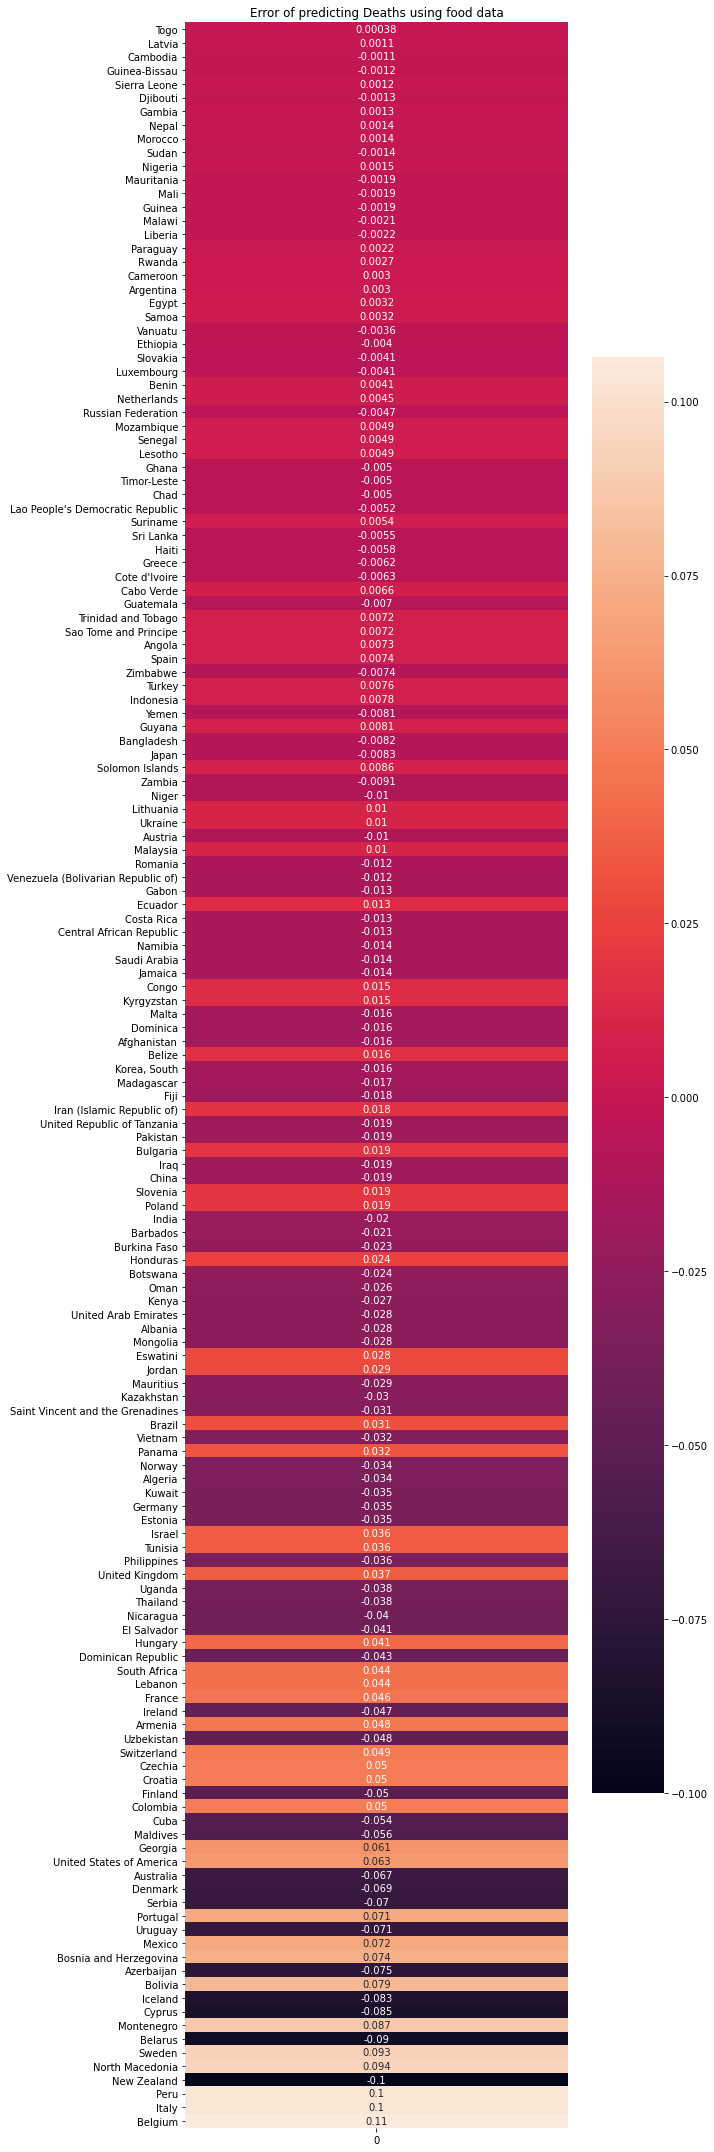

In [20]:
errors_food = [[val['actual'] - val['predicted']] for val in ordered_values]
countries_food = [val['country'] for val in ordered_values]

plt.figure(figsize=(10, 30))
sns.heatmap(errors_food, annot=True, yticklabels=countries_food)
plt.title("Error of predicting Deaths using food data")
plt.tight_layout()
plt.savefig('./results/error_predictions_heatmap_food.png')